# Text Classification (Sentiment Classification) - Amazon Alexa Reviews

- Dataset consists of 3000 Amazon customer reviews, star ratings, date of review, variant and feedback of various amazon Alexa products like Alexa Echo, Echo dots.
- The objective is to discover insights into consumer reviews and perfrom sentiment analysis on the data.
- Dataset: www.kaggle.com/sid321axn/amazon-alexa-reviews
---

<table>
  <tr><td>
    <img src="https://upload.wikimedia.org/wikipedia/commons/1/14/Amazon_Echo_Dot_%28black%29_on_a_wood_surface.jpg"
alt="Fashion MNIST sprite"  length = "600" width="800">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1. Amazon Alexa Reviews Classification [Source: https://en.wikipedia.org/wiki/Amazon_Echo]
  </td></tr>
</table>

## Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

print(f"Using Tensorflow version as - {tf.__version__}")

Using Tensorflow version as - 2.9.1


In [2]:
# Verify GPU availability and Usage

# Note this code is only valid if GPU is being used for training

# Before we run the parameter tuning, we will work with little gpu memory allocation
# we will only use that much of memory of gpu as it is needed - allow the growth of gpu memory as it is needed

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Load the Dataset

In [3]:
reviews = pd.read_csv('resources/amazon_alexa.tsv', sep="\t")

# Check the load
reviews.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
# Check the data structure
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [5]:
# Check for missing values
sum(reviews.isna().sum())

0

In [6]:
# Lets Check some positive reviews
reviews[reviews['feedback'] == 1]['verified_reviews'].head()

0                                        Love my Echo!
1                                            Loved it!
2    Sometimes while playing a game, you can answer...
3    I have had a lot of fun with this thing. My 4 ...
4                                                Music
Name: verified_reviews, dtype: object

In [7]:
# Lets Check some negative reviews
reviews[reviews['feedback'] == 0]['verified_reviews'].head()

46     It's like Siri, in fact, Siri answers more acc...
111    Sound is terrible if u want good music too get...
141                                   Not much features.
162    Stopped working after 2 weeks ,didn't follow c...
176                                 Sad joke. Worthless.
Name: verified_reviews, dtype: object

## Data Exploration

1    2893
0     257
Name: feedback, dtype: int64


<AxesSubplot:xlabel='feedback', ylabel='count'>

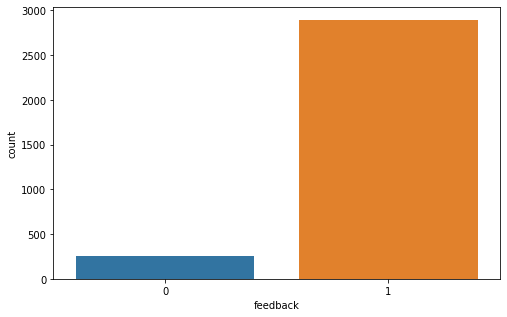

In [8]:
# Lets study the target variable
print(reviews['feedback'].value_counts())

# Check the distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='feedback', data=reviews)

<AxesSubplot:xlabel='rating', ylabel='count'>

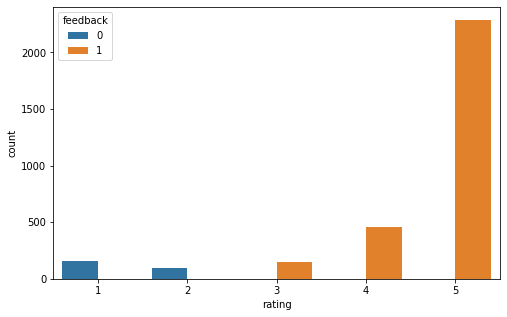

In [9]:
# Study the rating attribute
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=reviews, hue='feedback')

Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64


<AxesSubplot:xlabel='variation', ylabel='count'>

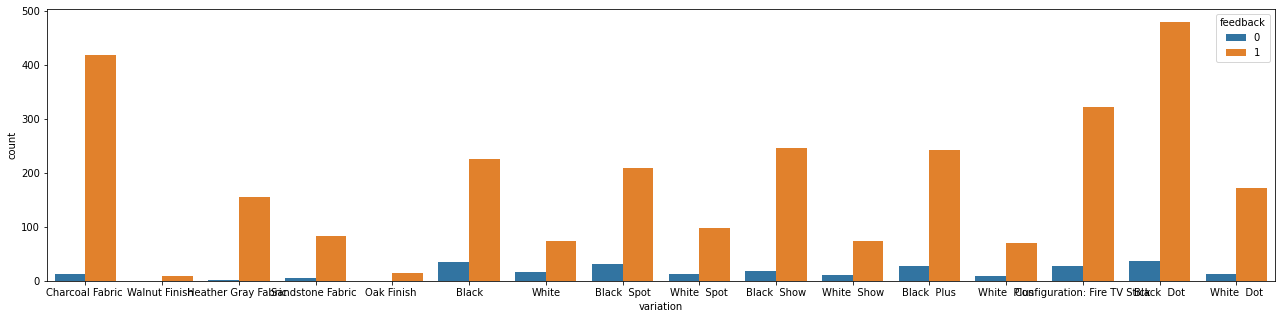

In [10]:
# Study the variation

# understand which variant how many reviews
print(reviews['variation'].value_counts())

# Variation by feedback
plt.figure(figsize=(22, 5))
sns.countplot(x='variation', data=reviews, hue='feedback')

## Data Preparation

In [11]:
# we will drop the date and rating attribute
reviews = reviews.drop(labels=['date', 'rating'], axis=1)

reviews.head()

,variation,verified_reviews,feedback
0,Charcoal Fabric,Love my Echo!,1
1,Charcoal Fabric,Loved it!,1
2,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,Charcoal Fabric,Music,1


In [12]:
reviews.head()

,variation,verified_reviews,feedback
0,Charcoal Fabric,Love my Echo!,1
1,Charcoal Fabric,Loved it!,1
2,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,Charcoal Fabric,Music,1


In [13]:
# Now we will onehot encode or create dummy variables for the variation attribute
variation_dummies = pd.get_dummies(reviews['variation'], drop_first=True)

# Now we will concatenate with the original dataframe
reviews = pd.concat([reviews, variation_dummies], axis=1)

# Also we will drop the variation attribute which has been one hot encoded
reviews = reviews.drop(labels=['variation'], axis=1)
reviews.head()

,verified_reviews,feedback,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,Love my Echo!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Loved it!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,"Sometimes while playing a game, you can answer...",1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,I have had a lot of fun with this thing. My 4 ...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Music,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### Demonstrate Count Vectorizer and Tokenization example

In [14]:
sample_data = ['This is the first document.', 'This document is the second document.', 'And this is the third one.', 
               'Is this the first document?']

# extract the unique feature from the sample_data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sample_data)

# Get the feature names
print(vectorizer.get_feature_names_out())

# The tokenizer array as per the feature names
print(X.toarray())


['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


### Implement Count Vectorizer and feature extractor for the verified reviews column

In [15]:
vectorizer = CountVectorizer() # what gets returned after implementing a vectorizer is a sparse matrix
reviews_vectorizer = vectorizer.fit_transform(reviews['verified_reviews'])

print(f'Shape of the vectorizer - {reviews_vectorizer.shape}')

Shape of the vectorizer - (3150, 4044)


In [16]:
# Check the feature names
print(vectorizer.get_feature_names_out())

['00' '000' '07' ... 'zzzz' 'zzzzzzz' 'útil']


In [17]:
# Convert the sparse martrix to array
reviews_vectorizer = reviews_vectorizer.toarray()
reviews_vectorizer

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [18]:
# Convert it to dataframe and concatenate with main dataframe
reviews_vectorizer = pd.DataFrame(reviews_vectorizer)
reviews = pd.concat([reviews_vectorizer, reviews], axis = 1)

# Drop the verified reviews attribute
reviews = reviews.drop(labels=['verified_reviews'], axis=1)

reviews.head()

,0,1,2,3,4,5,6,7,8,9,...,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
print(f"Shape of the final dataframe - {reviews.shape}")

Shape of the final dataframe - (3150, 4060)


## Perform train-test split

In [20]:
X = reviews.drop(labels=['feedback'], axis=1).values
y = reviews['feedback'].values

# reshape target for neural network feeding
y = y.reshape(-1, 1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

## Build and Train the Model

In [22]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=120, activation=tf.keras.activations.relu, input_shape=(X_train.shape[1], )))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(units=120, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

# Check the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               487200    
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               14520     
                                                                 
 dense_2 (Dense)             (None, 1)                 121       
                                                                 
Total params: 501,841
Trainable params: 501,841
Non-trainable params: 0
_________________________________________________________________


In [23]:
# train the model
epochs_hist = model.fit(X_train, y_train, epochs=70, validation_split=0.1, batch_size=100)

Epoch 1/70
23/23 [==============================] - 1s 12ms/step - loss: 0.4897 - binary_accuracy: 0.8977 - val_loss: 0.3769 - val_binary_accuracy: 0.9206
Epoch 2/70
23/23 [==============================] - 0s 5ms/step - loss: 0.2550 - binary_accuracy: 0.9180 - val_loss: 0.2107 - val_binary_accuracy: 0.9206
Epoch 3/70
23/23 [==============================] - 0s 6ms/step - loss: 0.1462 - binary_accuracy: 0.9242 - val_loss: 0.1889 - val_binary_accuracy: 0.9246
Epoch 4/70
23/23 [==============================] - 0s 5ms/step - loss: 0.0996 - binary_accuracy: 0.9550 - val_loss: 0.1758 - val_binary_accuracy: 0.9365
Epoch 5/70
23/23 [==============================] - 0s 5ms/step - loss: 0.0665 - binary_accuracy: 0.9740 - val_loss: 0.2007 - val_binary_accuracy: 0.9325
Epoch 6/70
23/23 [==============================] - 0s 5ms/step - loss: 0.0438 - binary_accuracy: 0.9854 - val_loss: 0.2171 - val_binary_accuracy: 0.9246
Epoch 7/70
23/23 [==============================] - 0s 5ms/step - loss: 0.0

## Evaluating the Model

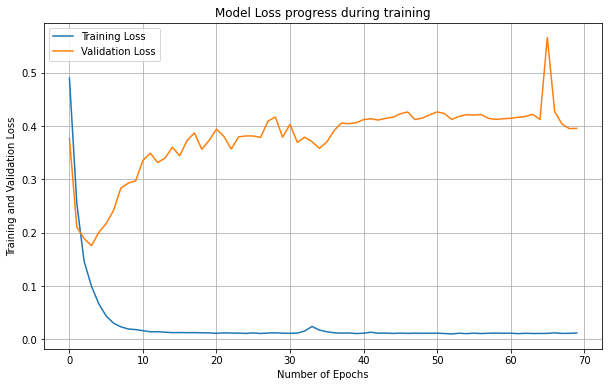

In [24]:
# Visualize the Model Loss
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title("Model Loss progress during training")
plt.xlabel("Number of Epochs")
plt.ylabel("Training and Validation Loss")
plt.legend(['Training Loss', 'Validation Loss'])

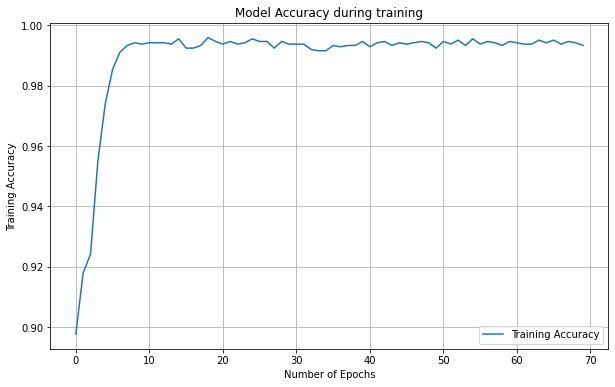

In [25]:
# Visualize the Model Accuracy
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(epochs_hist.history['binary_accuracy'])
plt.title("Model Accuracy during training")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Accuracy")
plt.legend(['Training Accuracy'])

In [26]:
# We will predict the test features
predictions = model.predict(X_test)

20/20 [==============================] - 0s 2ms/step


In [27]:
# So the target_predictions has probabilities, in order to use it in confusion matrix

predictions = (predictions > 0.5)

print('Confusion Matrix')
print(confusion_matrix(y_test, predictions))
print("\n")
print("Accuracy Score")
print(accuracy_score(y_test, predictions))
print("\n")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix
[[ 31  20]
 [ 21 558]]


Accuracy Score
0.9349206349206349


Classification Report
              precision    recall  f1-score   support

           0       0.60      0.61      0.60        51
           1       0.97      0.96      0.96       579

    accuracy                           0.93       630
   macro avg       0.78      0.79      0.78       630
weighted avg       0.94      0.93      0.94       630

